In [1]:
import math
import random
import seaborn
import matplotlib.pyplot as plt

from functools import partial
from collections import defaultdict
from gym.envs.toy_text import FrozenLakeEnv

from mctspy.tree import DecisionNode, MCTS
from mctspy.policies import uct_action
from mctspy.simluator import MCTSSimulator

In [2]:
class FrozenLakeMCTS(MCTSSimulator):

    def __init__(self, env):
        self.env = env

    def step(self, state, action):
        self.env.s = state
        next_state, reward, *_ = self.env.step(action)
        
        return next_state, reward, "agent_0"

    def state_is_terminal(self, state):
        return self.env.desc.flat[state] in (b"G", b"H")

    def enumerate_actions(self, state):
        return set(range(self.env.action_space.n))

    def get_initial_state(self):
        return self.env.reset(), "agent_0"

    def get_agent_num(self):
        return 1

    def get_current_agent(self, state):
        return "agent_0"

    def get_terminal_value(self, state):
        return {"agent_0": 0.0}

In [3]:
def random_rollout_value(state, env: FrozenLakeMCTS):
    """ Rollout the environment till terminal state with random actions.
    """
    cummulative_reward = defaultdict(int)

    while not env.state_is_terminal(state):
        agent_id = env.get_current_agent(state)
        state, reward, next_agent_id = env.step(
            state, 
            random.choice(tuple(env.enumerate_actions(state)))
        )
        cummulative_reward[agent_id] += reward
        agent_id = next_agent_id

    return cummulative_reward

## Optimal First Action experiment

Run MCTS with the budget of 1000 iterations for the first state of the 4x4 non-slippery Frozen Lake environment. Use UCB as the action selection policy and random rolout return as the state value estimator.

For the starting position `1` and `2` are the optimal actions. Compute the probability of MCTS root returning optimal action.


In [4]:
def test_optimal_first_action(n_tests=100):

    n_positive = 0

    for _ in range(n_tests):
        env = FrozenLakeEnv(is_slippery=False, map_name="4x4")
        env = FrozenLakeMCTS(env)

        initial_state, agent_id = env.get_initial_state()

        mcts = MCTS(env, uct_action, partial(random_rollout_value, env=env), 50)
        mcts_root = DecisionNode(initial_state, 0, {}, agent_id)

        # Build tree
        mcts.build_tree(mcts_root)

        # Get the best score in root Node
        best_score = max(chance_node.value / chance_node.visits for chance_node in mcts_root.children.values())

        # Compute scores for two optimal actions
        a1_score = mcts_root.children[1].value / mcts_root.children[1].visits
        a2_score = mcts_root.children[2].value / mcts_root.children[2].visits

        if a1_score == best_score or a2_score == best_score:
            n_positive += 1

    return n_positive / n_tests

In [5]:
res = []
for seed in range(200):
    random.seed(seed)
    res.append(test_optimal_first_action())

(0.5, 1.0)

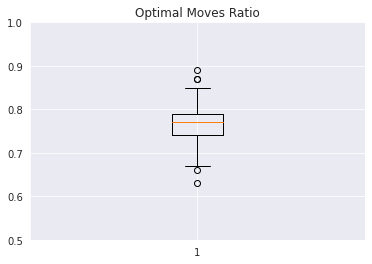

In [8]:
seaborn.set_style("darkgrid")

fig, ax = plt.subplots()
ax.boxplot(res)
ax.set_title("Optimal Moves Ratio")
ax.set_ylim([0.5, 1.0])

## Shortest Path Experiment

Ues MCTS with the budget of 1000 iterations as the policy to rollout the 4x4 non-slippery Frozen Lake environment. UCB is the action selection policy and random rolout return is the state value estimator.

Compute the probablity of MCTS finding the shortest path from the start to goal state.

In [6]:
n_tests = 100
n_positive = 0

for _ in range(n_tests):

    env = FrozenLakeEnv(is_slippery=False, map_name="4x4")
    env = FrozenLakeMCTS(env)

    state, agent_id = env.get_initial_state()
    trajectory = [state]

    mcts = MCTS(env, uct_action, partial(random_rollout_value, env=env), 1000)
    mcts_root = DecisionNode(state, 0, {}, agent_id)
    
    current = mcts_root

    while not env.state_is_terminal(state):
        # Compute the tree for the current node
        mcts.build_tree(current)

        # Select the best chance node according to UCB with 0 ecxploration
        action = uct_action(current, 0)
        state, reward, *_ = env.step(state, action)

        # Warm-start the MCTS tree for the next iteration
        current = current.children[action].children[state]
        
        trajectory.append(state)

    if len(trajectory) == 7:
        n_positive += 1

n_positive / n_tests

0.72